In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.metrics import accuracy, KappaScore
from fastai.vision import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

In [2]:
!ls ../input/resnet34/

resnet34.pth


In [3]:
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp ../input/resnet34/resnet34.pth /tmp/.cache/torch/checkpoints/resnet34.pth

In [4]:
!mv  /tmp/.cache/torch/checkpoints/resnet34.pth /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth

# Data

In [5]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
add_extension = lambda x: str(x) + '.png'
add_dir = lambda x: os.path.join('train_images', x)

In [7]:
train_df['diagnosis']=train_df['diagnosis'].apply(int)
train_df['id_code'] = train_df['id_code'].apply(add_extension)
train_df['id_code'] = train_df['id_code'].apply(add_dir)

In [8]:
train_df.head()

,id_code,diagnosis
0,train_images/000c1434d8d7.png,2
1,train_images/001639a390f0.png,4
2,train_images/0024cdab0c1e.png,1
3,train_images/002c21358ce6.png,0
4,train_images/005b95c28852.png,0


In [9]:
data_dir = Path('../input/aptos2019-blindness-detection/')

In [10]:
data = ImageDataBunch.from_df(data_dir, train_df, valid_pct=0.2, 
                              label_col='diagnosis', ds_tfms=get_transforms(), 
                              size=224).normalize(imagenet_stats)

In [11]:
data.classes

[0, 1, 2, 3, 4]

# Training

In [12]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, kappa], model_dir = Path('/kaggle/working/'))

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,1.210893,0.694101,0.745902,0.762158,07:48
1,0.884727,0.597741,0.777322,0.803339,07:40
2,0.739749,0.572708,0.780055,0.828910,07:40
3,0.649464,0.548886,0.781421,0.836684,07:37
4,0.620417,0.551513,0.797814,0.842276,07:32


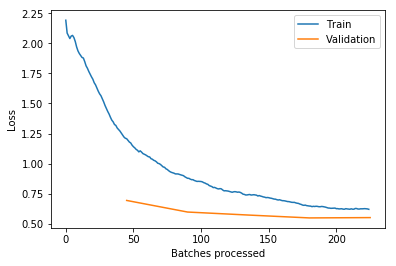

In [14]:
learn.fit_one_cycle(5)
learn.recorder.plot_losses()

In [15]:
import gc
gc.collect()

2608

In [16]:
# learn.unfreeze()

In [17]:
# learn.lr_find()

In [18]:
# learn.recorder.plot()

In [19]:
# learn.fit_one_cycle(8, max_lr=slice(8e-6, 2e-5))
# learn.recorder.plot_losses()

# Test

In [20]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [21]:
test_df['diagnosis'] = pd.Series(np.zeros(len(test_df['id_code'])), index=test_df.index)

In [22]:
test_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0.0
1,003f0afdcd15,0.0
2,006efc72b638,0.0
3,00836aaacf06,0.0
4,009245722fa4,0.0


In [23]:
learn.data.add_test(ImageList.from_df(test_df,'../input/aptos2019-blindness-detection/',folder='test_images',suffix='.png'))

In [24]:
preds,y = learn.get_preds(DatasetType.Test)

In [25]:
test_df.diagnosis = preds.argmax(1)
test_df.head()

,id_code,diagnosis
0,0005cfc8afb6,4
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,4


In [26]:
test_df.to_csv('submission.csv',index=False)